# **Import Statements**

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from utils.data_management import Mat2TVT, Preprocessor, Custom_EMG, Jitter, MaskRand
from models.RNN_rect import EMG_RNN
from utils.training_overhead import Trainer

%load_ext autoreload
%autoreload 2

torch.cuda.is_available()

True

# **Data Reorganization** <br>
Reorganizing provided matlab file and interpolating over recoverable NaN labels

For a single trial, 

- Marker kinematics are provided at 400 Hz, shape (300, 3) --> 0.75 s
- EMG information is provided at 6103.5 Hz, shape (4564,) --> 0.7478 s

Marker and EMG data are time-synced. Blinking starts at around 0.25 seconds, which corresponds to point 100 for the kinematics data and point 1525 in the EMG data

Since only electrodes u1, u2, u3, u4, and t2 were used in common across all participants, our input to the model (without spectral preprocessing) will be of shape (4564, N, 5). Since only markerset x1, x2, A, B, C, D, E were used in common across all participants, our labels will be of shape (N, 7, 300, 3). In other words, $x \in R^{T_{\mathrm{in}}\times N \times C_{\mathrm{in}}}$, where $T_{\mathrm{in}}$ is the number of timesteps (4564, in this case), N is the batch size, and $C_{\mathrm{in}}$ is the number of channels (5, in this case), while $y \in R^{T_{\mathrm{out}}\times 3\times N \times C_{\mathrm{out}}}$, where where $T_{\mathrm{out}}$ is the number of timesteps (300 x 3, in this case), N is the batch size, and $C_{\mathrm{out}}$ is the number of channels (7, in this case).

To reorganize the data for train-test-val splits, the Nth data/label pair should contain the timeseries for emg electrodes u1, u2, u3, u4, t2/the timeseries for markerset x1, x2, A, B, C, D, E. In addition to this, a static identification label is generated which contains an identifying string combining the subject, blink type, and trial number (ie: 'sub1_spon#23'), a boolean hyperparameter indicating eye side (True = Right Eye, False = Left Eye); and a flag to identify whether the trial contains NaN values. 

In [36]:
eye_bool = np.asarray([True, True, False, True, True, False, False, False])
electrode_list = ['u1', 'u2', 'u3', 'u4', 't2']
marker_list = ['u1', 'u2', 'u3', 'u4', 'u5']
filepath = 'eyeliddata.mat'

train = 0.7
val = 0.2
test = 0.1

reorganizer = Mat2TVT(eye_bool, electrode_list, marker_list, filepath)
_, _, identifier = reorganizer.load_data()
X, y = reorganizer.DMVC_norm()
TVT_dict = reorganizer.TVT_split(train, val, test)


X_train, y_train = TVT_dict["X_train"], TVT_dict["y_train"]
X_val, y_val = TVT_dict["X_val"], TVT_dict["y_val"]
X_test, y_test = TVT_dict["X_test"], TVT_dict["y_test"]

'''
Shape Validation
'''
#Validate shapes
print("Data Shape: ", X.shape)
print("Label Shape: ", y.shape)
print("Identifier Shape: ", identifier.shape)
assert X.shape[0] == 4564, "X Shape Invalid: Should have 4564 timesteps"
assert X.shape[2] == len(electrode_list), "X Shape Invalid: Incorrect channel count"
assert y.shape[0] == 300, "y Shape Invalid: Should have 300 timesteps"
assert y.shape[1] == 3, "y Shape Invalid: Each timestep should have 3 (cartesian) dimensions"
assert y.shape[3] == len(marker_list), "y Shape Invalid: Incorrect channel count"
assert X.shape[1] == y.shape[2] == identifier.shape[0], "Shapes Invalid: The trial dimension of X, y, and identifier needs to match"
print("Shapes Validated!")

Data Shape:  (4564, 977, 5)
Label Shape:  (300, 3, 977, 5)
Identifier Shape:  (977, 3)
Shapes Validated!


# **Models** <br>

t is worth pointing out that the data I have is not surface EMG data but data collected by needles inserted into the obicularis muscle. This means that there is finer resolution into picking up signals from individual motor units, which means that it is possible that there is enough information captured in the rectified EMG signal to recreate eyelid motions, without adding a pre-processing step to aquire the spectral form of the data. The ultimate goal is performance, which means that it is worth testing the model architectures with rectified EMG inputs vs spectral encoding, as well as if there is extra time, a combined model architecture which would accept spectral and rectified EMG. 

**Preprocessing**: Since it is impossible to insert needle electrodes into exactly the same location on the obicularis for each subject, and individuals have variance in their ability to activate their muscles, the first step of data preprocessing is to perform dynamic maximum voluntary contraction normalization on the EMG data, where we normalize to unit statistics each channel on each subject. Because we expect the relative eye motion to be important (rather than the absolute location of the eye motion), all of the labels are shifted so that their minimum value lies at y = 0. This should hopefully enable the model to learn the desired shape of the eyelid trajectory across subjects without obfuscation(ie: a blink whose x coordinate moves from -4 to -6 is the same type of blink as one whose x coordinate moves from -8 to -10). 

Since the desired application is a real-time model of eyelid kinematics directly informed by the EMG behavior of the obicularis muscle, we need to break our data into windows. Thus, window length and window stride will end up being hyperparameters that we optimize for with Ray Tune, and for simplicity we'll use 'same' padding. This means that our input to the model will actually be of shape $X \in R^{L \times N_w \times N_b \times C}$ where $L$ is the length of our window, $N_w$ is the number of windows in a batch, $N_b$ is the number of examples in a batch, and $C$ is the number of channels present in the data (in this case, 5). Once the data is windowed, the next step in preprocessing is to either identify the frquency spectrum or to rectify the data. 

**Data Augmentation**: timeseries jitter + SpecAugment

# **Preprocessing**

In [119]:
t_win = 20
t_lookahead = 50
t_stride = 10
batch_size = 64
p_transform = 0.3
sigma = 0.3
p_mask = 0.1

#Window and rectify the EMG data
preprocessor = Preprocessor(t_win, t_lookahead, t_stride)
X_train_wr, y_train_wr = preprocessor.win_rect(X_train, y_train)
X_val_wr, y_val_wr = preprocessor.win_rect(X_val, y_val)

#Load into custom torch.Dataset object, which applies our data augmentation (Jitter, random masking)
transform = v2.RandomApply(torch.nn.ModuleList([Jitter(sigma), MaskRand(p_mask)]), p = p_transform)

train_data = Custom_EMG(X_train_wr, y_train_wr, transform = transform)
train_dataloader = DataLoader(train_data, batch_size, shuffle = True)

val_data = Custom_EMG(X_val_wr, y_val_wr, transform = transform)
val_dataloader = DataLoader(val_data, batch_size, shuffle = True)




trial, label = train_data.__getitem__(0)
print(trial.shape, label.shape)


train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(train_features.device, train_labels.device)

torch.Size([122, 68, 5]) torch.Size([4, 3, 68, 5])
Feature batch shape: torch.Size([64, 122, 68, 5])
Labels batch shape: torch.Size([64, 4, 3, 68, 5])
cuda:0 cuda:0


In [142]:
dropout = 0.3
learning_rate = 1e-4
epochs = 20

model = EMG_RNN(train_features.size(), train_labels.size(), 2, dropout)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

trainer = Trainer(train_dataloader, val_dataloader, model, loss_fn, optimizer, batch_size, epochs)
t_loss, v_loss = trainer.train()

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 423.3%, Avg Marker Error: 100.0%, Avg loss: 10.287276 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 349.6%, Avg Marker Error: 99.4%, Avg loss: 10.186398 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 420.8%, Avg Marker Error: 99.7%, Avg loss: 10.590183 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 430.6%, Avg Marker Error: 99.5%, Avg loss: 9.761950 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 392.3%, Avg Marker Error: 99.3%, Avg loss: 10.727097 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 437.1%, Avg Marker Error: 99.5%, Avg loss: 10.983146 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 429.0%, Avg Marker Error: 100.3%, Avg loss: 9.179763 

Epoch 8
-------------------------------
Validation Error: 
 Max Marke

# **Plotting Loss Metrics**

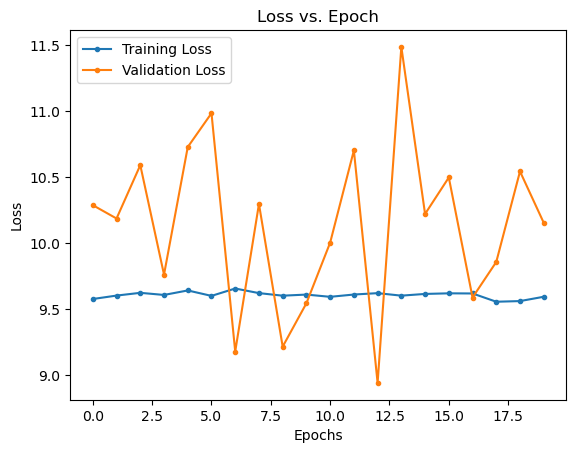

In [143]:
plt.plot(np.arange(epochs), t_loss, label = 'Training Loss', marker = '.')
plt.plot(np.arange(epochs), v_loss, label = 'Validation Loss', marker = '.')
plt.title('Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
